In [1]:
# OpenGym CartPole-v0 with A3C on GPU
# -----------------------------------
#
# A3C implementation with GPU optimizer threads.
# 
# Made as part of blog series Let's make an A3C, available at
# https://jaromiru.com/2017/02/16/lets-make-an-a3c-theory/
#
# author: Jaromir Janisch, 2017

import numpy as np
import tensorflow as tf

import gym, time, random, threading

from keras.models import *
from keras.layers import *
from keras import backend as K

#-- constants
ENV = 'CartPole-v0'

RUN_TIME = 30
THREADS = 8
OPTIMIZERS = 2
THREAD_DELAY = 0.001

GAMMA = 0.99

N_STEP_RETURN = 8
GAMMA_N = GAMMA ** N_STEP_RETURN

EPS_START = 0.4
EPS_STOP  = .15
EPS_STEPS = 75000

MIN_BATCH = 32
LEARNING_RATE = 5e-3

LOSS_V = .5			# v loss coefficient
LOSS_ENTROPY = .01 	# entropy coefficient

#---------
class Brain:
	train_queue = [ [], [], [], [], [] ]	# s, a, r, s', s' terminal mask
	lock_queue = threading.Lock()

	def __init__(self):
		self.session = tf.Session()
		K.set_session(self.session)
		K.manual_variable_initialization(True)

		self.model = self._build_model()
		self.graph = self._build_graph(self.model)

		self.session.run(tf.global_variables_initializer())
		self.default_graph = tf.get_default_graph()

		self.default_graph.finalize()	# avoid modifications

	def _build_model(self):

		l_input = Input( batch_shape=(None, NUM_STATE) )
		l_dense = Dense(16, activation='relu')(l_input)

		out_actions = Dense(NUM_ACTIONS, activation='softmax')(l_dense)
		out_value   = Dense(1, activation='linear')(l_dense)

		model = Model(inputs=[l_input], outputs=[out_actions, out_value])
		model._make_predict_function()	# have to initialize before threading

		return model

	def _build_graph(self, model):
		s_t = tf.placeholder(tf.float32, shape=(None, NUM_STATE))
		a_t = tf.placeholder(tf.float32, shape=(None, NUM_ACTIONS))
		r_t = tf.placeholder(tf.float32, shape=(None, 1)) # not immediate, but discounted n step reward
		
		p, v = model(s_t)

		log_prob = tf.log( tf.reduce_sum(p * a_t, axis=1, keep_dims=True) + 1e-10)
		advantage = r_t - v

		loss_policy = - log_prob * tf.stop_gradient(advantage)									# maximize policy
		loss_value  = LOSS_V * tf.square(advantage)												# minimize value error
		entropy = LOSS_ENTROPY * tf.reduce_sum(p * tf.log(p + 1e-10), axis=1, keep_dims=True)	# maximize entropy (regularization)

		loss_total = tf.reduce_mean(loss_policy + loss_value + entropy)

		optimizer = tf.train.RMSPropOptimizer(LEARNING_RATE, decay=.99)
		minimize = optimizer.minimize(loss_total)

		return s_t, a_t, r_t, minimize

	def optimize(self):
		if len(self.train_queue[0]) < MIN_BATCH:
			time.sleep(0)	# yield
			return

		with self.lock_queue:
			if len(self.train_queue[0]) < MIN_BATCH:	# more thread could have passed without lock
				return 									# we can't yield inside lock

			s, a, r, s_, s_mask = self.train_queue
			self.train_queue = [ [], [], [], [], [] ]

		s = np.vstack(s)
		a = np.vstack(a)
		r = np.vstack(r)
		s_ = np.vstack(s_)
		s_mask = np.vstack(s_mask)

		if len(s) > 5*MIN_BATCH: print("Optimizer alert! Minimizing batch of %d" % len(s))

		v = self.predict_v(s_)
		r = r + GAMMA_N * v * s_mask	# set v to 0 where s_ is terminal state
		
		s_t, a_t, r_t, minimize = self.graph
		self.session.run(minimize, feed_dict={s_t: s, a_t: a, r_t: r})

	def train_push(self, s, a, r, s_):
		with self.lock_queue:
			self.train_queue[0].append(s)
			self.train_queue[1].append(a)
			self.train_queue[2].append(r)

			if s_ is None:
				self.train_queue[3].append(NONE_STATE)
				self.train_queue[4].append(0.)
			else:	
				self.train_queue[3].append(s_)
				self.train_queue[4].append(1.)

	def predict(self, s):
		with self.default_graph.as_default():
			p, v = self.model.predict(s)
			return p, v

	def predict_p(self, s):
		with self.default_graph.as_default():
			p, v = self.model.predict(s)		
			return p

	def predict_v(self, s):
		with self.default_graph.as_default():
			p, v = self.model.predict(s)		
			return v

#---------
frames = 0
class Agent:
	def __init__(self, eps_start, eps_end, eps_steps):
		self.eps_start = eps_start
		self.eps_end   = eps_end
		self.eps_steps = eps_steps

		self.memory = []	# used for n_step return
		self.R = 0.

	def getEpsilon(self):
		if(frames >= self.eps_steps):
			return self.eps_end
		else:
			return self.eps_start + frames * (self.eps_end - self.eps_start) / self.eps_steps	# linearly interpolate

	def act(self, s):
		eps = self.getEpsilon()			
		global frames; frames = frames + 1

		if random.random() < eps:
			return random.randint(0, NUM_ACTIONS-1)

		else:
			s = np.array([s])
			p = brain.predict_p(s)[0]

			# a = np.argmax(p)
			a = np.random.choice(NUM_ACTIONS, p=p)

			return a
	
	def train(self, s, a, r, s_):
		def get_sample(memory, n):
			s, a, _, _  = memory[0]
			_, _, _, s_ = memory[n-1]

			return s, a, self.R, s_

		a_cats = np.zeros(NUM_ACTIONS)	# turn action into one-hot representation
		a_cats[a] = 1 

		self.memory.append( (s, a_cats, r, s_) )

		self.R = ( self.R + r * GAMMA_N ) / GAMMA

		if s_ is None:
			while len(self.memory) > 0:
				n = len(self.memory)
				s, a, r, s_ = get_sample(self.memory, n)
				brain.train_push(s, a, r, s_)

				self.R = ( self.R - self.memory[0][2] ) / GAMMA
				self.memory.pop(0)		

			self.R = 0

		if len(self.memory) >= N_STEP_RETURN:
			s, a, r, s_ = get_sample(self.memory, N_STEP_RETURN)
			brain.train_push(s, a, r, s_)

			self.R = self.R - self.memory[0][2]
			self.memory.pop(0)	
	
	# possible edge case - if an episode ends in <N steps, the computation is incorrect
		
#---------


#---------
class Optimizer(threading.Thread):
	stop_signal = False

	def __init__(self):
		threading.Thread.__init__(self)

	def run(self):
		while not self.stop_signal:
			brain.optimize()

	def stop(self):
		self.stop_signal = True



Using TensorFlow backend.


In [4]:
from IPython import display
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

class Environment(threading.Thread):
	stop_signal = False

	def __init__(self, render=False, eps_start=EPS_START, eps_end=EPS_STOP, eps_steps=EPS_STEPS):
		threading.Thread.__init__(self)

		self.render = render
		self.env = gym.make(ENV)
		self.agent = Agent(eps_start, eps_end, eps_steps)

	def runEpisode(self):
		s = self.env.reset()
		if self.render:
			img = plt.imshow(self.env.render(mode='rgb_array')) # only call this once

		R = 0
		while True:         
			time.sleep(THREAD_DELAY) # yield 

			if self.render:
				img.set_data(self.env.render(mode='rgb_array')) # just update the data
				display.display(plt.gcf())
				display.clear_output(wait=True)

			a = self.agent.act(s)
			s_, r, done, info = self.env.step(a)

			# modify the reward to encourage it stay near the middle
			# s_'s first value is position from -2.4 to +2.4
			r -= abs(s_[0]/10)

			if done: # terminal state
				s_ = None

			self.agent.train(s, a, r, s_)

			s = s_
			R += r

			if done or self.stop_signal:
				break

		print("Total R:", R)

	def run(self):
		while not self.stop_signal:
			self.runEpisode()

	def stop(self):
		self.stop_signal = True


In [6]:
#-- main
env_test = Environment(render=True, eps_start=0., eps_end=0.)
NUM_STATE = env_test.env.observation_space.shape[0]
NUM_ACTIONS = env_test.env.action_space.n
NONE_STATE = np.zeros(NUM_STATE)

brain = Brain()	# brain is global in A3C

envs = [Environment() for i in range(THREADS)]
opts = [Optimizer() for i in range(OPTIMIZERS)]

for o in opts:
	o.start()

for e in envs:
	e.start()

print("timer starts...")
time.sleep(RUN_TIME)
print("times up")

for e in envs:
	e.stop()
for e in envs:
	e.join()

for o in opts:
	o.stop()
for o in opts:
	o.join()

print("Training finished")

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
keep_dims is deprecated, use keepdims instead
Instructions for updating:
Use tf.cast instead.
timer starts...
Total R: 12.933833677572476
Total R: 13.942030465135783
Total R: 14.926160496952901
Total R: 16.880821120633424
Total R: 21.920215996620996
Total R: 20.7651482697642
Total R: 23.925836005186053
Total R: 8.941135253059032
Total R: 23.86129246507758
Total R:Total R: 11.91229302687304
 12.928856327594339
Total R: 11.945265721223711
Total R: 16.917038044264462
Total R: 19.817997693756222
Total R: 16.8274994672159
Total R: 14.918991310655393
Total R: 10.905044571669432
Total R: 10.956986115208215
Total R: 21.97832497042986
Total R: 12.928130684580712
Total R: 11.928774751753041
Total R: 9.959377071091765
Total R: 13.897167501700295
Total R: 12.950408477985421
Total R: 18.813003444224705
Total R: 15.96377222930874
Total R:Total R: 12.938151724673364
 28.71044497835783
Total R: 18.898266

Total R:Total R: 21.943615244746166
 14.908308238876629
Total R: 13.833440238971097
Total R: 18.944310605281828
Total R: 17.917029683799964
Total R: 12.874535186826192
Total R: 13.916218671493425
Total R: 22.949070631623215
Total R: 43.87394551298172
Total R: 12.904138059508048
Total R:Total R: 27.880033057251254
Total R: 23.8753241892273
 8.916541230239723
Total R: 28.8638317150872
Total R: 16.907339902381842
Total R: 29.940373772518537
Total R: 10.951647639978157
Total R: 10.883068436780794
Total R: Total R:10.965184578796928 8.96565194877309

Total R: 16.916098137308865
Total R: 9.956420953963667
Total R: 18.95075131437887
Total R: 9.956425622572917
Total R: 12.92561908522667
Total R: 14.940563414797666
Total R: 25.898226641621022
Total R: 22.835659661722314
Total R: 18.950067249840547
Total R: 39.584070340966804
Total R: 12.956399674143901
Total R: 15.924616181492993
Total R: 11.931920538995772
Total R: 45.789902375691845
Total R: 13.911163828141644
Total R: 25.93619048586874
Total

Total R: 182.36088984283344
Total R: 94.0648358850948
Total R: 83.21166807183731
Total R: 56.52501691584108
Total R: 118.08455240246128
Total R: 150.76120133933128
Total R: 25.945956383736835
Total R: 88.16482058140582
Total R: 24.822923221859163
Total R: 29.823058810412224
Total R: 26.930469821176388
Total R: 119.89415579211685
Total R: 18.9084204304517
Total R: 98.74210301263638
Total R: 101.6664215951831
Total R: 69.93482631636567
Total R: 90.54018968155344
Total R: 27.820533655210667
Total R: 14.918119729331432
Total R: 101.48599807501192
Total R: 186.96844238380191
Total R: 43.59434552851526
Total R: 185.6770535957899
Total R: 178.42308671460432
Total R: 150.6269111656186
Total R: 79.984248936661
Total R: 110.8282690293052
Total R: 164.5506972442991
Total R: 53.550976387758105
Total R: 115.53764785284493
Total R: 172.9427356521537
Total R: 32.931500210190926
Total R: 15.862292984382517
Total R: 69.24226871358161
Total R: 132.27120413187157
Total R: 175.11554396673287
Total R: 190.

Total R: 162.6832850026277
Total R: 169.56960610714566
Total R: 183.89126505023984
Total R: 183.38774485960792
Total R: 188.9771383244356
Total R: 184.1682206006768
Total R: 167.92683974102533
Total R: 175.17409664543558
Total R: 184.27901299486174
Total R: 183.97722967477517
Total R: 134.81315805553822
Total R: 183.56185998014251
Total R: 176.80670047996466
Total R: 159.76971853560565
Total R: 176.9958915914033
Total R: 177.9679823666406
Total R: 155.49949325093914
Total R: 152.88929378820245
Total R: 181.30873613247263
Total R: 159.19483965657002
Total R: 182.9732842866252
Total R: 153.2076251330363
Total R: 146.93440243680212
Total R: 135.5816029313564
Total R: 141.1332206546898
Total R: 170.97438696708744
Total R: 177.2914380626231
Total R: 47.550830019225934
Total R: 162.92507298115132
Total R: 166.70643054497737
Total R: 160.8808955868198
Total R: 187.13454185157605
Total R: 185.77660599816
Total R: 144.68869718842876
Total R: 180.2912725681212
Total R: 33.94810020622596
Total R:

Total R: 185.16975301639417
Total R: 187.13849734273498
Total R: 187.49197175156453
Total R: 184.31919227188462
Total R: 187.461908488174
Total R: 187.62276911679626
Total R: 184.7948939622821
Total R: 184.6907249612466
Total R: 188.1494191928147
Total R: 186.56989437648275
Total R: 188.43170201120066
Total R: 188.77881438023692
Total R: 189.49047124704472
Total R: 190.3177832662378
Total R: 189.91958357204533
Total R: 185.92322091568164
Total R: 135.57228809599863
Total R: 192.19598033945815
Total R: 67.57499451216891
Total R: 185.92944381854238
Total R: 191.70907799240172
Total R: 195.0761630176829
Total R: 195.5888796729684
Total R: 194.56877719328287
Total R: 194.80724275855752
Total R: 83.34901468998272
Total R: 77.58275434234262
Total R: 196.2132479173345
Total R: 193.34931098339948
Total R: 194.53650011434968
Total R: 196.23851945710967
Total R: 194.27046605168638
Total R: 193.36618944374428
Total R: 193.3064914378444
Total R: 99.37161973862281
Total R: 193.79937690216386
Total 

KeyboardInterrupt: 

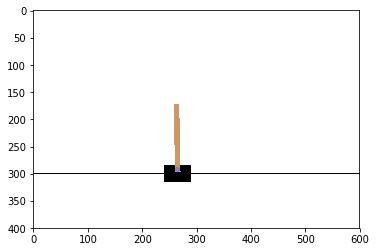

In [7]:
env_test = Environment(render=True, eps_start=0., eps_end=0.)
env_test.run()

In [ ]:
env = gym.make(ENV)
env.reset()


In [ ]:

print(env.step(env.action_space.sample()))